In [1]:
MODEL_TYPE = 'protenix'
VALIDATION = True

## Install requirements 

In [2]:
#if MODEL_TYPE=='protenix' and VALIDATION:
!pip install --no-deps protenix
!pip install biopython
!pip install ml-collections
!pip install biotite==1.0.1
!pip install rdkit
!export PROTENIX_DATA_ROOT_DIR=/kaggle/input/protenix-checkpoints

In [3]:
! mkdir /af3-dev 
! ln -s /kaggle/input/protenix-checkpoints /af3-dev/release_data
! ls /af3-dev/release_data/

components.v20240608.cif		model_v0.2.0.pt
components.v20240608.cif.rdkit_mol.pkl


## Helper scripts

In [4]:
import Bio

from copy import deepcopy

import pandas as pd
from Bio.PDB import Atom, Model, Chain, Residue, Structure, PDBParser
from Bio import SeqIO
import os, sys
import re
import numpy as np
import torch

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
time0=time.time()

print('IMPORT OK !!!!')

IMPORT OK !!!!


In [5]:
PYTHON = sys.executable
print('PYTHON',PYTHON)

RHONET_DIR=\
'/kaggle/input/data-for-demo-for-rhofold-plus-with-kaggle-msa/RhoFold-main'
#'<your downloaded rhofold repo>/RhoFold-main'

USALIGN = \
'/kaggle/working//USalign'
#'<your us align path>/USalign'

os.system('cp /kaggle/input/usalign/USalign /kaggle/working/')
os.system('sudo chmod u+x /kaggle/working//USalign')
sys.path.append(RHONET_DIR)


DATA_KAGGLE_DIR = '/kaggle/input/stanford-rna-3d-folding'


# helper ----
class dotdict(dict):
	__setattr__ = dict.__setitem__
	__delattr__ = dict.__delitem__

	def __getattr__(self, name):
		try:
			return self[name]
		except KeyError:
			raise AttributeError(name)

# visualisation helper ----
def set_aspect_equal(ax):
	x_limits = ax.get_xlim()
	y_limits = ax.get_ylim()
	z_limits = ax.get_zlim()

	# Compute the mean of each axis
	x_middle = np.mean(x_limits)
	y_middle = np.mean(y_limits)
	z_middle = np.mean(z_limits)

	# Compute the max range across all axes
	max_range = max(x_limits[1] - x_limits[0],
					y_limits[1] - y_limits[0],
					z_limits[1] - z_limits[0]) / 2.0

	# Set the new limits to ensure equal scaling
	ax.set_xlim(x_middle - max_range, x_middle + max_range)
	ax.set_ylim(y_middle - max_range, y_middle + max_range)
	ax.set_zlim(z_middle - max_range, z_middle + max_range)




# xyz df helper --------------------
def get_truth_df(target_id):
    truth_df = LABEL_DF[LABEL_DF['target_id'] == target_id]
    truth_df = truth_df.reset_index(drop=True)
    return truth_df

def parse_output_to_df(output, seq, target_id):
    df = []
    chain_data = []
    for i, res in enumerate(seq):
        d=dict(ID = target_id,
                    resname=res,
                    resid=i+1)
        for n in range(len(output)):
            d={**d, f'x_{n+1}': round(output[n,i,0].item(),3),
                     f'y_{n+1}': round(output[n,i,1].item(),3),
                     f'z_{n+1}': round(output[n,i,2].item(),3)}
        chain_data.append(d)

    if len(chain_data)!=0:
        chain_df = pd.DataFrame(chain_data)
        df.append(chain_df)
        ##print(chain_df)
    return df

def parse_pdb_to_df(pdb_file, target_id):
    parser = PDBParser()
    structure = parser.get_structure('', pdb_file)

    df = []
    for model in structure:
        for chain in model:
            print(chain)
            chain_data = []
            for residue in chain:
                # print(residue)
                if residue.get_resname() in ['A', 'U', 'G', 'C']:
                    # Check if the residue has a C1' atom
                    if 'C1\'' in residue:
                        atom = residue['C1\'']
                        xyz = atom.get_coord()
                        resname = residue.get_resname()
                        resid = residue.get_id()[1]

                        #todo detect discontinous: resid = prev_resid+1
                        #ID	resname	resid	x_1	y_1	z_1
                        chain_data.append(dict(
                            ID = target_id+'_'+str(resid),
                            resname=resname,
                            resid=resid,
                            x_1=xyz[0],
                            y_1=xyz[1],
                            z_1=xyz[2],
                        ))
                        ##print(f"Residue {resname} {resid}, Atom: {atom.get_name()}, xyz: {xyz}")

            if len(chain_data)!=0:
                chain_df = pd.DataFrame(chain_data)
                df.append(chain_df)
                ##print(chain_df)
    return df

# usalign helper --------------------
def write_target_line(
    atom_name, atom_serial, residue_name, chain_id, residue_num, x_coord, y_coord, z_coord, occupancy=1.0, b_factor=0.0, atom_type='P'
):
    """
    Writes a single line of PDB format based on provided atom information.

    Args:
        atom_name (str): Name of the atom (e.g., "N", "CA").
        atom_serial (int): Atom serial number.
        residue_name (str): Residue name (e.g., "ALA").
        chain_id (str): Chain identifier.
        residue_num (int): Residue number.
        x_coord (float): X coordinate.
        y_coord (float): Y coordinate.
        z_coord (float): Z coordinate.
        occupancy (float, optional): Occupancy value (default: 1.0).
        b_factor (float, optional): B-factor value (default: 0.0).

    Returns:
        str: A single line of PDB string.
    """
    return f'ATOM  {atom_serial:>5d}  {atom_name:<5s} {residue_name:<3s} {residue_num:>3d}    {x_coord:>8.3f}{y_coord:>8.3f}{z_coord:>8.3f}{occupancy:>6.2f}{b_factor:>6.2f}           {atom_type}\n'

def write_xyz_to_pdb(df, pdb_file, xyz_id = 1):
    resolved_cnt = 0
    with open(pdb_file, 'w') as target_file:
        for _, row in df.iterrows():
            x_coord = row[f'x_{xyz_id}']
            y_coord = row[f'y_{xyz_id}']
            z_coord = row[f'z_{xyz_id}']

            if x_coord > -1e17 and y_coord > -1e17 and z_coord > -1e17:
                resolved_cnt += 1
                target_line = write_target_line(
                    atom_name="C1'",
                    atom_serial=int(row['resid']),
                    residue_name=row['resname'],
                    chain_id='0',
                    residue_num=int(row['resid']),
                    x_coord=x_coord,
                    y_coord=y_coord,
                    z_coord=z_coord,
                    atom_type='C',
                )
                target_file.write(target_line)
    return resolved_cnt

def parse_usalign_for_tm_score(output):
    # Extract TM-score based on length of reference structure (second)
    tm_score_match = re.findall(r'TM-score=\s+([\d.]+)', output)[1]
    if not tm_score_match:
        raise ValueError('No TM score found')
    return float(tm_score_match)

def parse_usalign_for_transform(output):
    # Locate the rotation matrix section
    matrix_lines = []
    found_matrix = False

    for line in output.splitlines():
        if "The rotation matrix to rotate Structure_1 to Structure_2" in line:
            found_matrix = True
        elif found_matrix and re.match(r'^\d+\s+[-\d.]+\s+[-\d.]+\s+[-\d.]+\s+[-\d.]+$', line):
            matrix_lines.append(line)
        elif found_matrix and not line.strip():
            break  # Stop parsing if an empty line is encountered after the matrix

    # Parse the rotation matrix values
    rotation_matrix = []
    for line in matrix_lines:
        parts = line.split()
        row_values = list(map(float, parts[1:]))  # Skip the first column (index)
        rotation_matrix.append(row_values)

    return np.array(rotation_matrix)

def call_usalign(predict_df, truth_df, verbose=1):
    truth_pdb = '~truth.pdb'
    predict_pdb = '~predict.pdb'
    write_xyz_to_pdb(predict_df, predict_pdb, xyz_id=1)
    write_xyz_to_pdb(truth_df, truth_pdb, xyz_id=1)

    command = f'{USALIGN} {predict_pdb} {truth_pdb} -atom " C1\'" -m -'
    output = os.popen(command).read()
    if verbose==1:
        print(output)
    tm_score = parse_usalign_for_tm_score(output)
    transform = parse_usalign_for_transform(output)
    return tm_score, transform

print('HELPER OK!!!')

PYTHON /usr/bin/python3
HELPER OK!!!


In [6]:
if MODEL_TYPE=='protenix':
    
    
    from runner.batch_inference import get_default_runner
    from runner.inference import update_inference_configs, InferenceRunner

    from protenix.data.infer_data_pipeline import InferenceDataset

    np.random.seed(0)
    torch.random.manual_seed(0)
    torch.cuda.manual_seed_all(0)

    class DictDataset(InferenceDataset):
        def __init__(
            self,
            seq_list: list,
            dump_dir: str,
            id_list: list = None,
            use_msa: bool = False,
        ) -> None:

            self.dump_dir = dump_dir
            self.use_msa = use_msa
            if isinstance(id_list,type(None)):
                self.inputs = [{"sequences": 
                                [{"rnaSequence": 
                                  {"sequence": seq, 
                                   "count": 1}}],
                                "name": "query"} for seq in seq_list]
            else:
                self.inputs = [{"sequences": 
                                [{"rnaSequence": 
                                  {"sequence": seq, 
                                   "count": 1}}],
                                "name": i} for i, seq in zip(id_list,seq_list)]

In [7]:
if MODEL_TYPE=='protenix':

    from configs.configs_base import configs as configs_base
    from configs.configs_data import data_configs
    from configs.configs_inference import inference_configs
    from protenix.config.config import parse_configs

    configs_base["use_deepspeed_evo_attention"] = (
    os.environ.get("USE_DEEPSPEED_EVO_ATTENTION", False) == "true")
    configs_base["model"]["N_cycle"] = 10 #10
    configs_base["sample_diffusion"]["N_sample"] = (1 if VALIDATION else 5)
    configs_base["sample_diffusion"]["N_step"] = 200
    inference_configs['load_checkpoint_path']='/kaggle/input/protenix-checkpoints/model_v0.2.0.pt'
    configs = {**configs_base, **{"data": data_configs}, **inference_configs}

    configs = parse_configs(
            configs=configs,
            fill_required_with_null=True,
        )
    
    runner=InferenceRunner(configs)


train scheduler 16.0
inference scheduler 16.0
Diffusion Module has 16.0


/usr/local/lib/python3.10/dist-packages/runner/inference.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, self.device)


In [8]:
VALIDATION

True

In [9]:
if VALIDATION:
    LABEL_DF = pd.read_csv('/kaggle/input/stanford-rna-3d-folding/train_labels.csv')
    LABEL_DF.rename(columns={'x_1': 'x_true', 'y_1': 'y_true', 'z_1': 'z_true'}, inplace=True)
    LABEL_DF['target_id'] = LABEL_DF['ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))
    train_df=pd.read_csv('/kaggle/input/folding-strategy-rna/rna_dataset_with_fold.csv')
    train_df = train_df[train_df['fold']==1]
    train_df.reset_index(drop=True, inplace=True)

In [10]:
train_df

,target_id,sequence,temporal_cutoff,description,all_sequences,sequence_length,fold
0,1FFK_9,UUAGGCGGCCACAGCGGUGGGGUUGCCUCCCGUACCCAUCCCGAAC...,2000-08-14,CRYSTAL STRUCTURE OF THE LARGE RIBOSOMAL SUBUN...,>1FFK_1|Chain A[auth 0]|23S RRNA|Haloarcula ma...,122,1
1,1FOQ_A,UCAAUGGUACGGUACUUCCAUUGUCAUGUGUAUGUUGGGGAUUAAA...,2000-12-22,PENTAMERIC MODEL OF THE BACTERIOPHAGE PHI29 PR...,">1FOQ_1|Chains A, B, C, D, E|BACTERIOPHAGE PHI...",120,1
2,1S9S_A,GGCGGUACUAGUUGAGAAACUAGCUCUGUAUCUGGCGGACCCGUGG...,2004-04-06,SOLUTION STRUCTURE OF MLV PSI SITE,>1S9S_1|Chain A|MLV Psi encapsidation site|nul...,101,1
3,1ZC8_Z,GCCCGUCACGCCAUGGGAGCGGGCUCUACCCGAAGUCGCCGGGAGC...,2005-04-19,"Coordinates of tmRNA, SmpB, EF-Tu and h44 fitt...",>1ZC8_1|Chain A|TLD 16S ribosomal RNA|Thermus ...,91,1
4,1YSH_B,UAGACGGUGGGAGAGGGUGGUGGAAUUCCCGGAGUAGCGGUGAAAU...,2005-07-05,Localization and dynamic behavior of ribosomal...,>1YSH_1|Chain A|RNA (28-MER)|synthetic constru...,101,1
...,...,...,...,...,...,...,...
173,9G7C_A,GGGAGUCGGGUCUGUGGUUGAAAGUCGAUGCCAGUCGCAGGCGAAA...,2024-10-30,Cryo-EM structure of raiA ncRNA from Clostridi...,>9G7C_1|Chain A|raiA (224-MER)|Clostridium sp....,224,1
174,8T3E_EC,AAACUCCAUGUAUUGGUUACCCAUCUGCAUCGAAAACUCUCCGAAC...,2024-12-11,Hypomethylated yeast 80S bound with Taura synd...,>8T3E_1|Chain A[auth BA]|40S ribosomal protein...,202,1
175,8T3F_EC,AAACUCCAUGUAUUGGUUACCCAUCUGCAUCGAAAACUCUCCGAAC...,2024-12-11,Hypomethylated yeast 80S bound with Taura synd...,>8T3F_1|Chain A[auth BA]|40S ribosomal protein...,202,1
176,8Z1G_T,GGUAAAAUGGCUGAGUGAAGCAUUGGACUGUAAAUCUAAAGACAGG...,2024-12-18,Cryo-EM structure of human ELAC2-pre-tRNA,>8Z1G_1|Chain A[auth T]|Homo sapiens mitochond...,86,1


100%|██████████| 178/178 [1:00:17<00:00, 20.32s/it]

nan


<Axes: >

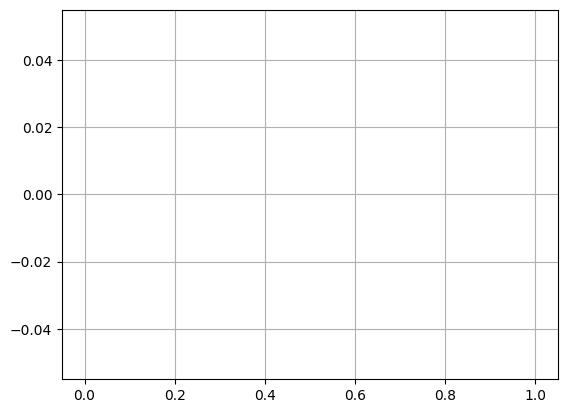

In [11]:
import warnings
warnings.filterwarnings("ignore")  

train_df['protenix_tm_score'] = None
dataset                       = DictDataset(train_df.sequence, dump_dir='output', id_list=train_df.target_id, use_msa=False)
num_data                      = len(dataset)

if MODEL_TYPE=='protenix' and VALIDATION:
    for i, seq in tqdm(enumerate(train_df.sequence), total=num_data):
        if train_df.loc[i,'protenix_tm_score']!=None:
            continue
        if len(seq)>300:
            continue
            
        target_id = train_df.loc[i,'target_id']
        truth_df  = get_truth_df(target_id)
        
        if sum(~np.isnan(truth_df.x_true))<3:
            continue
            
        data, atom_array, data_error_message=dataset[i]
        
        if data_error_message!='':
            continue
            
        new_configs   = update_inference_configs(configs, data["N_token"].item())
        runner.update_model_configs(new_configs)
        prediction    = runner.predict(data)
        prediction    = prediction['coordinate'][:,data['input_feature_dict']['atom_to_tokatom_idx']==12]       
        result        = parse_output_to_df(prediction[:1], seq, target_id)[0]
        try:
            tm_score, transform                 = call_usalign(result, truth_df, verbose=0)
            train_df.loc[i,'protenix_tm_score'] = tm_score
        except:
            pass
            
        if (time.time()-time0)>(12*3600-360):
            break


        result['ID']=result.apply(lambda x: x.ID + '_' + str(x.resid), axis=1)
        result.to_csv('proteinx_oof.csv', index=False, mode='a', header=(i==0))
        torch.cuda.empty_cache()
            
    train_df.to_csv('tm_scores.csv', index=False)
    print(train_df.protenix_tm_score.mean())
    display(train_df.protenix_tm_score.hist())

In [12]:
# import warnings
# warnings.filterwarnings("ignore") 

# test_df=pd.read_csv('/kaggle/input/stanford-rna-3d-folding/test_sequences.csv') 

# dataset = DictDataset(test_df.sequence, dump_dir='output', id_list=test_df.target_id, use_msa=False)
# num_data = len(dataset)

# if MODEL_TYPE=='protenix' and not VALIDATION:
#     for i, seq in tqdm(enumerate(test_df.sequence),total=num_data):
#         try:
            
#             data, atom_array, data_error_message = dataset[i]
#             target_id                            = data["sample_name"]
#             assert target_id==test_df.target_id[i]
#             assert data_error_message==''
            
#             new_configs  = update_inference_configs(configs, data["N_token"].item())
#             runner.update_model_configs(new_configs)
#             prediction   = runner.predict(data)
#             prediction   = prediction['coordinate'][:,data['input_feature_dict']['atom_to_tokatom_idx']==12]
#             result       = parse_output_to_df(prediction, seq, target_id)[0]
            
#         except:
#             target_id==test_df.target_id[i]
#             print('Failed to predict', target_id)
#             result=pd.DataFrame(columns=['ID', 'resname', 'resid', 
#                                          'x_1', 'y_1', 'z_1', 
#                                          'x_2', 'y_2', 'z_2',
#                                          'x_3', 'y_3', 'z_3', 
#                                          'x_4', 'y_4', 'z_4', 
#                                          'x_5', 'y_5', 'z_5'], 
#                                          data=[[target_id, x, j+1] + [0.0]*15 for j, x in enumerate(seq)])
            
#         result['ID']=result.apply(lambda x: x.ID + '_' + str(x.resid), axis=1)
#         result.to_csv('submission.csv', index=False, mode='a', header=(i==0))
#         torch.cuda.empty_cache()

#     display(pd.read_csv('submission.csv'))